# F1 Race Strategy — **MLP Final** (Stable & Report-Ready)
This notebook trains a robust **multi-task MLP** to predict:
- **y1**: next stint length (regression)
- **y2**: next tire compound (classification)

What’s new vs earlier versions:
- **Robust preprocessing** (replace ±Inf → NaN → impute; OHE for cats; scale nums)
- **Stable MLP** (no BatchNorm/LayerNorm), **Xavier init**, **grad clipping**
- **Class weighting** for y2, **early stopping** on Macro-F1, **ReduceLROnPlateau**
- NaN-safe metrics, predictions table, artifact saving for Streamlit


## 0) Optional installs (run if needed)

In [ ]:
# %pip install --upgrade scikit-learn joblib --quiet
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu --quiet
# %pip install streamlit --quiet

## 1) Imports & paths

In [1]:
import numpy as np, pandas as pd, joblib
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, confusion_matrix, top_k_accuracy_score
from sklearn.utils.class_weight import compute_class_weight

import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader



## 2) Load data & select columns

In [3]:
df = pd.read_csv('f1_strategy_modeling_dataset.csv')
CATS = ["season","circuit","driver_code","constructor","tire_compound"]
NUMS = [
    "position","stint","stint_length","pit_lap","pit_time",
    "air_temp_c","track_temp_c","humidity_pct","wind_kmh",
    "lap_time_variation","tire_usage_aggr","fast_lap_attempts","position_changes","driver_aggr_score"
]
TARGETS = ["y1_next_stint_length","y2_next_compound"]
use_cols = CATS + NUMS + TARGETS + ["race_key"]
df = df[use_cols].copy()

# y2 must exist
df = df.dropna(subset=["y2_next_compound"]).reset_index(drop=True)
y2_classes = sorted(df["y2_next_compound"].astype(str).unique().tolist())
df["y2_idx"] = pd.Categorical(df["y2_next_compound"], categories=y2_classes).codes
df.shape, y2_classes

((4553, 23),
 ['HARD',
  'HYPERSOFT',
  'INTERMEDIATE',
  'MEDIUM',
  'SOFT',
  'SUPERSOFT',
  'ULTRASOFT',
  'WET'])

## 3) Leave-race-out split (fold 0) + robust preprocessing

In [5]:
gkf = GroupKFold(n_splits=5)
splits = list(gkf.split(df.index.values, groups=df["race_key"].values))
train_df = df.iloc[splits[0][0]].reset_index(drop=True)
val_df   = df.iloc[splits[0][1]].reset_index(drop=True)

# Replace ±Inf in numerics with NaN first
for d in (train_df, val_df):
    d[NUMS] = d[NUMS].replace([np.inf, -np.inf], np.nan)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

pre = ColumnTransformer([
    ("cat", cat_pipe, CATS),
    ("num", num_pipe, NUMS),
])

X_train = pre.fit_transform(train_df[CATS+NUMS])
X_val   = pre.transform(val_df[CATS+NUMS])
y1_tr = train_df["y1_next_stint_length"].to_numpy(dtype="float32")
y1_va = val_df["y1_next_stint_length"].to_numpy(dtype="float32")
y2_tr = train_df["y2_idx"].to_numpy(dtype="int64")
y2_va = val_df["y2_idx"].to_numpy(dtype="int64")

print("X_train finite? ", np.isfinite(X_train).all())
print("X_val   finite? ", np.isfinite(X_val).all())

X_train finite?  True
X_val   finite?  True


## 4) Stable MLP (no Norm layers) + class weights

In [7]:
cls_w = compute_class_weight(class_weight="balanced", classes=np.arange(len(y2_classes)), y=y2_tr).astype("float32")
cls_w_t = torch.tensor(cls_w)

class TabDS(Dataset):
    def __init__(self, X, y1, y2):
        self.X  = torch.from_numpy(X).float()
        self.y1 = torch.from_numpy(y1).float()
        self.y2 = torch.from_numpy(y2).long()
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y1[i], self.y2[i]

train_dl = DataLoader(TabDS(X_train, y1_tr, y2_tr), batch_size=512, shuffle=True, drop_last=True)
Xv_t = torch.from_numpy(X_val).float()

class MLPStable(nn.Module):
    def __init__(self, in_dim, n_classes, p=0.30):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(), nn.Dropout(p),
            nn.Linear(512, 256), nn.ReLU(), nn.Dropout(p),
            nn.Linear(256, 128), nn.ReLU(), nn.Dropout(p),
        )
        self.h1 = nn.Linear(128, 1)          # y1
        self.h2 = nn.Linear(128, n_classes)  # y2
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                nn.init.zeros_(m.bias)
    def forward(self, x):
        h = self.net(x)
        return self.h1(h).squeeze(-1), self.h2(h)

model = MLPStable(X_train.shape[1], len(y2_classes), p=0.30)
opt = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4, eps=1e-8)
reg_loss = nn.SmoothL1Loss(reduction="none")
cls_loss = nn.CrossEntropyLoss(weight=cls_w_t)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", factor=0.5, patience=2)

## 5) Train with early stopping (maximize val Macro-F1)

In [22]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, top_k_accuracy_score

history = {
    "epoch": [],
    "train_loss": [],
    "val_f1": [],
    "val_acc": [],
    "val_bacc": [],
    "val_top2": [],
    "val_mae": [],
    "val_rmse": [],
}


In [24]:
EPOCHS = 40
patience, bad = 6, 0
best = {"score": -1, "state": None}

for ep in range(1, EPOCHS+1):
    # -------- train --------
    model.train(); total = 0.0
    for xb, y1b, y2b in train_dl:
        p1, p2 = model(xb)
        m = ~torch.isnan(y1b)
        loss_reg = reg_loss(p1[m], y1b[m]).mean() if m.any() else torch.tensor(0.0)
        loss_cls = cls_loss(p2, y2b)
        loss = loss_reg + loss_cls
        if torch.isnan(loss) or torch.isinf(loss):
            continue
        opt.zero_grad(); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()
        total += loss.item() * xb.size(0)

    # -------- validate --------
    model.eval()
    with torch.no_grad():
        p1_v, p2_v = model(Xv_t)
        probs_v = torch.softmax(p2_v, dim=1).detach().cpu().numpy()
        y2_pred = probs_v.argmax(1)

    # y2 metrics
    val_f1   = float(f1_score(y2_va, y2_pred, average="macro"))
    val_acc  = float(accuracy_score(y2_va, y2_pred))
    val_bacc = float(balanced_accuracy_score(y2_va, y2_pred))
    val_top2 = float(top_k_accuracy_score(y2_va, probs_v, k=2))

    # y1 metrics
    y1_pred = p1_v.detach().cpu().numpy()
    mask = np.isfinite(y1_va) & np.isfinite(y1_pred)
    val_mae  = float(mean_absolute_error(y1_va[mask], y1_pred[mask])) if mask.any() else np.nan
    val_rmse = float(mean_squared_error(y1_va[mask], y1_pred[mask], squared=False)) if mask.any() else np.nan

    scheduler.step(val_f1)

    # log
    history["epoch"].append(ep)
    history["train_loss"].append(total/len(train_dl.dataset))
    history["val_f1"].append(val_f1)
    history["val_acc"].append(val_acc)
    history["val_bacc"].append(val_bacc)
    history["val_top2"].append(val_top2)
    history["val_mae"].append(val_mae)
    history["val_rmse"].append(val_rmse)

    print(f"Epoch {ep:02d} | train_loss={history['train_loss'][-1]:.4f} | "
          f"val_y2_MacroF1={val_f1:.3f} | val_acc={val_acc:.3f} | top2={val_top2:.3f} | "
          f"y1_MAE={val_mae:.2f}")

    # early stop on F1
    if val_f1 > best["score"] and not np.isnan(val_f1):
        best["score"] = val_f1
        best["state"] = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

# restore best
if best["state"] is not None:
    model.load_state_dict(best["state"])


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 01 | train_loss=6.2273 | val_y2_MacroF1=0.341 | val_acc=0.484 | top2=0.752 | y1_MAE=5.36


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 02 | train_loss=5.9936 | val_y2_MacroF1=0.339 | val_acc=0.480 | top2=0.751 | y1_MAE=5.42


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 03 | train_loss=6.0270 | val_y2_MacroF1=0.340 | val_acc=0.481 | top2=0.748 | y1_MAE=5.32


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 04 | train_loss=6.0316 | val_y2_MacroF1=0.346 | val_acc=0.486 | top2=0.749 | y1_MAE=5.23


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 05 | train_loss=5.8665 | val_y2_MacroF1=0.335 | val_acc=0.486 | top2=0.747 | y1_MAE=5.25


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 06 | train_loss=6.0010 | val_y2_MacroF1=0.338 | val_acc=0.487 | top2=0.753 | y1_MAE=5.30


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 07 | train_loss=5.9057 | val_y2_MacroF1=0.326 | val_acc=0.482 | top2=0.756 | y1_MAE=5.22


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 08 | train_loss=5.9468 | val_y2_MacroF1=0.325 | val_acc=0.481 | top2=0.756 | y1_MAE=5.26


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Epoch 09 | train_loss=5.8794 | val_y2_MacroF1=0.324 | val_acc=0.479 | top2=0.752 | y1_MAE=5.28
Epoch 10 | train_loss=5.9614 | val_y2_MacroF1=0.328 | val_acc=0.480 | top2=0.748 | y1_MAE=5.24
Early stopping.


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 6) Final evaluation + predictions table

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y1 → MAE: 5.258 | RMSE: 7.459
y2 → Macro-F1: 0.337 | Top-2 Acc: 0.755


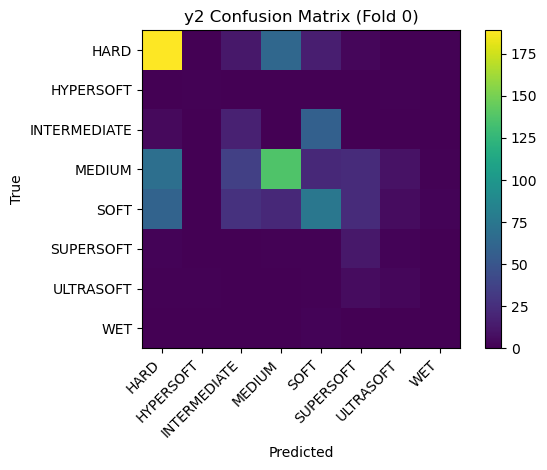

,y1_true_next_stint_len,y1_pred_next_stint_len,y1_abs_error,y2_true,y2_pred,y2_top2
0,24.0,28.128773,4.128773,SOFT,ULTRASOFT,"[ULTRASOFT, SUPERSOFT]"
1,20.0,23.351589,3.351589,MEDIUM,ULTRASOFT,"[ULTRASOFT, SUPERSOFT]"
2,31.0,14.305940,16.694061,MEDIUM,SUPERSOFT,"[SUPERSOFT, MEDIUM]"
3,4.0,9.305952,5.305952,SOFT,SUPERSOFT,"[SUPERSOFT, HYPERSOFT]"
4,30.0,33.002941,3.002941,MEDIUM,ULTRASOFT,"[ULTRASOFT, MEDIUM]"
5,27.0,32.969608,5.969608,MEDIUM,ULTRASOFT,"[ULTRASOFT, MEDIUM]"
6,26.0,26.797668,0.797668,MEDIUM,ULTRASOFT,"[ULTRASOFT, MEDIUM]"
7,6.0,1.816979,4.183021,MEDIUM,WET,"[WET, INTERMEDIATE]"
8,36.0,36.241531,0.241531,MEDIUM,ULTRASOFT,"[ULTRASOFT, MEDIUM]"
9,25.0,17.252998,7.747002,MEDIUM,SUPERSOFT,"[SUPERSOFT, ULTRASOFT]"


In [11]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    p1, p2 = model(Xv_t)
y1_pred = p1.detach().cpu().numpy()
probs   = torch.softmax(p2, dim=1).detach().cpu().numpy()
y2_pred = probs.argmax(1)

mask = np.isfinite(y1_va) & np.isfinite(y1_pred)
y1_mae  = float(mean_absolute_error(y1_va[mask], y1_pred[mask])) if mask.any() else np.nan
y1_rmse = float(mean_squared_error(y1_va[mask], y1_pred[mask], squared=False)) if mask.any() else np.nan
y2_f1   = float(f1_score(y2_va, y2_pred, average="macro"))
top2    = float(top_k_accuracy_score(y2_va, probs, k=2))
print(f"y1 → MAE: {y1_mae:.3f} | RMSE: {y1_rmse:.3f}")
print(f"y2 → Macro-F1: {y2_f1:.3f} | Top-2 Acc: {top2:.3f}")

cm = confusion_matrix(y2_va, y2_pred, labels=list(range(len(y2_classes))))
plt.figure(); plt.imshow(cm, interpolation='nearest'); plt.title('y2 Confusion Matrix (Fold 0)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.xticks(range(len(y2_classes)), y2_classes, rotation=45, ha='right'); plt.yticks(range(len(y2_classes)), y2_classes)
plt.colorbar(); plt.tight_layout(); plt.show()

pred_df = pd.DataFrame({
    "y1_true_next_stint_len": y1_va,
    "y1_pred_next_stint_len": y1_pred,
    "y1_abs_error": np.abs(y1_pred - y1_va),
    "y2_true": [y2_classes[i] for i in y2_va],
    "y2_pred": [y2_classes[i] for i in y2_pred],
    "y2_top2": [[y2_classes[j] for j in probs[i].argsort()[-2:][::-1]] for i in range(len(probs))],
})
pred_df.head(20)

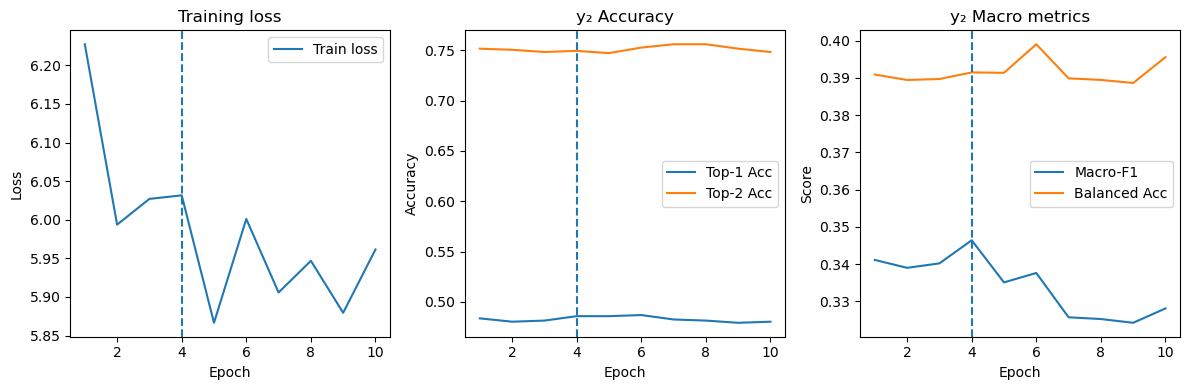

Best epoch by Macro-F1: 4  (Macro-F1=0.346)


In [26]:
import matplotlib.pyplot as plt
import numpy as np

ep = np.array(history["epoch"])

# helper to mark best epoch (by Macro-F1)
best_idx = int(np.argmax(history["val_f1"]))
best_ep = history["epoch"][best_idx]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(ep, history["train_loss"], label="Train loss")
plt.axvline(best_ep, linestyle="--")
plt.title("Training loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,3,2)
plt.plot(ep, history["val_acc"], label="Top-1 Acc")
plt.plot(ep, history["val_top2"], label="Top-2 Acc")
plt.axvline(best_ep, linestyle="--")
plt.title("y₂ Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,3,3)
plt.plot(ep, history["val_f1"], label="Macro-F1")
plt.plot(ep, history["val_bacc"], label="Balanced Acc")
plt.axvline(best_ep, linestyle="--")
plt.title("y₂ Macro metrics"); plt.xlabel("Epoch"); plt.ylabel("Score"); plt.legend()

plt.tight_layout()
plt.show()s

print(f"Best epoch by Macro-F1: {best_ep}  (Macro-F1={history['val_f1'][best_idx]:.3f})")


## 7) Save artifacts for Streamlit

In [13]:
joblib.dump(pre, "preprocessor.joblib")
torch.save({
    "state_dict": model.state_dict(),
    "input_dim": X_train.shape[1],
    "y2_classes": y2_classes
}, "mlp_fold0.pt")
pred_df.to_csv("mlp_fold0_val_predictions.csv", index=False)
print("Saved: preprocessor.joblib, mlp_fold0.pt, mlp_fold0_val_predictions.csv")

Saved: preprocessor.joblib, mlp_fold0.pt, mlp_fold0_val_predictions.csv


## 8) (Optional) 5-fold CV (stable variant)

In [15]:
def run_fold(train_idx, val_idx):
    tr = df.iloc[train_idx].reset_index(drop=True)
    va = df.iloc[val_idx].reset_index(drop=True)
    for d in (tr, va):
        d[NUMS] = d[NUMS].replace([np.inf, -np.inf], np.nan)
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', ohe)])
    num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
    pre = ColumnTransformer([('cat', cat_pipe, CATS), ('num', num_pipe, NUMS)])
    Xtr = pre.fit_transform(tr[CATS+NUMS])
    Xva = pre.transform(va[CATS+NUMS])
    y1_tr = tr['y1_next_stint_length'].to_numpy(dtype='float32')
    y1_va = va['y1_next_stint_length'].to_numpy(dtype='float32')
    y2_tr = tr['y2_idx'].to_numpy(dtype='int64')
    y2_va = va['y2_idx'].to_numpy(dtype='int64')
    cls_w = compute_class_weight('balanced', classes=np.arange(len(y2_classes)), y=y2_tr).astype('float32')
    cls_w_t = torch.tensor(cls_w)
    dl = DataLoader(TabDS(Xtr, y1_tr, y2_tr), batch_size=512, shuffle=True, drop_last=True)
    Xva_t = torch.from_numpy(Xva).float()
    mdl = MLPStable(Xtr.shape[1], len(y2_classes))
    opt = torch.optim.AdamW(mdl.parameters(), lr=5e-4, weight_decay=1e-4, eps=1e-8)
    reg = nn.SmoothL1Loss(reduction='none'); cls = nn.CrossEntropyLoss(weight=cls_w_t)
    best = {'score': -1, 'state': None}
    for ep in range(20):
        mdl.train()
        for xb, y1b, y2b in dl:
            p1, p2 = mdl(xb); m = ~torch.isnan(y1b)
            loss = (reg(p1[m], y1b[m]).mean() if m.any() else 0.0) + cls(p2, y2b)
            if torch.isnan(loss) or torch.isinf(loss):
                continue
            opt.zero_grad(); loss.backward(); nn.utils.clip_grad_norm_(mdl.parameters(), 1.0); opt.step()
        mdl.eval();
        with torch.no_grad(): _, p2v = mdl(Xva_t)
        f1 = float(f1_score(y2_va, p2v.argmax(-1).numpy(), average='macro'))
        if f1 > best['score'] and not np.isnan(f1):
            best['score'] = f1
            best['state'] = {k: v.detach().cpu().clone() for k,v in mdl.state_dict().items()}
    if best['state'] is not None:
        mdl.load_state_dict(best['state'])
    with torch.no_grad(): p1v, p2v = mdl(Xva_t)
    p1_np = p1v.numpy(); mask = np.isfinite(y1_va) & np.isfinite(p1_np)
    y1_mae = float(mean_absolute_error(y1_va[mask], p1_np[mask])) if mask.any() else np.nan
    y1_rmse = float(mean_squared_error(y1_va[mask], p1_np[mask], squared=False)) if mask.any() else np.nan
    y2_f1 = float(f1_score(y2_va, p2v.argmax(-1).numpy(), average='macro'))
    return y1_mae, y1_rmse, y2_f1

fold_metrics = []
for k,(tri,vai) in enumerate(gkf.split(df.index.values, groups=df['race_key'].values)):
    print(f"Fold {k}..."); fold_metrics.append(run_fold(tri, vai))
arr = np.array(fold_metrics, dtype=float)
print("\nFOLD METRICS [MAE, RMSE, Macro-F1]:\n", arr)
print("\nMEAN ± STD:")
print("MAE   :", f"{arr[:,0].mean():.3f} ± {arr[:,0].std():.3f}")
print("RMSE  :", f"{arr[:,1].mean():.3f} ± {arr[:,1].std():.3f}")
print("F1    :", f"{arr[:,2].mean():.3f} ± {arr[:,2].std():.3f}")

Fold 0...


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1...


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2...


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3...


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4...

FOLD METRICS [MAE, RMSE, Macro-F1]:
 [[ 5.56326103  7.71375465  0.30549504]
 [ 5.90533304  7.58396292  0.28942484]
 [ 5.53651667  7.72244501  0.34787133]
 [ 5.92678213  7.82371712  0.29171876]
 [ 9.16590118 11.96439266  0.32157867]]

MEAN ± STD:
MAE   : 6.420 ± 1.383
RMSE  : 8.562 ± 1.703
F1    : 0.311 ± 0.022


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 9) Inference helper for a single row
Use a dict with the same fields as training to test predictions.

In [17]:
def predict_row(row_dict):
    X_row = pd.DataFrame([row_dict])[CATS + NUMS]
    X_proc = pre.transform(X_row).astype('float32')
    Xt = torch.tensor(X_proc)
    model.eval();
    with torch.no_grad(): y1, y2 = model(Xt)
    y1_val = float(y1.numpy()[0])
    pr = torch.softmax(y2, dim=1).numpy()[0]
    top = int(pr.argmax())
    top3 = {y2_classes[i]: float(pr[i]) for i in pr.argsort()[-3:][::-1]}
    return y1_val, y2_classes[top], top3

# Example usage
example = val_df.iloc[0][CATS + NUMS].to_dict()
predict_row(example)

(28.128772735595703,
 'ULTRASOFT',
 {'ULTRASOFT': 0.6377049684524536,
  'SUPERSOFT': 0.13823308050632477,
  'MEDIUM': 0.09464775025844574})